# Monarch Migration Project
<h3>Capstone Project for Data Analytics Certificate<br>
Google / The Mom Project RISE Program<br><br>
Samantha Goodman
<br>sje.goodman@protonmail.com
<br>January 2022</h3><br>
This project aims to:<br>
    <ul><li>Find the median latitudes of observed migration events for the years 2015-2020</li>
<li>Visualize the fall migration for a specific year (2019) </li></ul>
This notebook has 4 parts:<br>
        1 - Loading<br>
        2 - Cleaning<br>
        3 - Mapping Fall Migration Latitudes<br>
        4 - Animated Gif<br>
        5 - Interactive Map<br>


<H3>Data Source Info:</H3>

Package ID: edi.949.1 Cataloging System:https://pasta.edirepository.org.
<br>Data set title: Journey North - Monarch Butterfly and Milkweed observations by volunteer community scientists across Central and North America (1996-2020).
<br>Data set creator:  Nancy Sheehan - University of Wisconsin - Madison Arboretum, Journey North Program 
<br>Data set creator:  Luis Weber-Grullon - University of Wisconsin - Madison 
<br>Contact:  Nancy Sheehan - Program Coordinator University of Wisconsin - Madison Arboretum, Journey North Program  - nsheehan@wisc.edu
<br>Stylesheet v1.0 for metadata conversion into program: John H. Porter, Univ. Virginia, jporter@virginia.edu      


In [207]:
#Import Libraries
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import folium
from folium import plugins

# Import libraries for animated gif
import os
import time

import imageio
import webbrowser
import fileinput
from folium import IFrame
from os import path
from selenium import webdriver
from PIL import Image
from pathlib import Path

# 1: Load the Data

In [165]:
# Read file from package
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/949/1/02f2be4d90198702c46fa36556f3749a".strip() 
infile1  = infile1.replace("https://","http://")

In [166]:
# Read CSV
dt1 =pd.read_csv(infile1 
          ,skiprows=1
            ,sep=","  
                ,quotechar='"' 
           , names=[
                    "id",     
                    "sighting_date",     
                    "species",     
                    "number",     
                    "latitude",     
                    "longitude",     
                    "flag_location",     
                    "comments",     
                    "school",     
                    "grade",     
                    "image_url",     
                    "customerid",     
                    "number_old",     
                    "flag_number",     
                    "species_old",     
                    "flag_species"    ]

          ,parse_dates=[
                        'sighting_date',
                ] 
            ,na_values={
                  'comments':[
                          '-999999.999',],
                  'school':[
                          '-999999.999',],
                  'grade':[
                          '-999999.999',],
                  'image_url':[
                          '-999999.999',],
                  'number_old':[
                          '-999999.999',],
                  'species_old':[
                          '-999999.999',],} 
            
    )

In [167]:
# Coerce the data into the types specified in the metadata  
dt1.id=dt1.id.astype('category') 
# Since date conversions are tricky, the coerced dates will go into a new column with _datetime appended
# This new column is added to the dataframe but does not show up in automated summaries below. 
dt1=dt1.assign(sighting_date_datetime=pd.to_datetime(dt1.sighting_date,errors='coerce'))  
dt1.species=dt1.species.astype('category') 
dt1.number=pd.to_numeric(dt1.number,errors='coerce',downcast='integer') 
dt1.latitude=pd.to_numeric(dt1.latitude,errors='coerce') 
dt1.longitude=pd.to_numeric(dt1.longitude,errors='coerce')  
dt1.flag_location=dt1.flag_location.astype('category')  
dt1.comments=dt1.comments.astype('category')  
dt1.school=dt1.school.astype('category')  
dt1.grade=dt1.grade.astype('category')  
dt1.image_url=dt1.image_url.astype('category')  
dt1.customerid=dt1.customerid.astype('category') 
dt1.number_old=pd.to_numeric(dt1.number_old,errors='coerce')  
dt1.flag_number=dt1.flag_number.astype('category')  
dt1.species_old=dt1.species_old.astype('category')  
dt1.flag_species=dt1.flag_species.astype('category') 

In [168]:
dt1.head()

,id,sighting_date,species,number,latitude,longitude,flag_location,comments,school,grade,image_url,customerid,number_old,flag_number,species_old,flag_species,sighting_date_datetime
0,850841703,1996-12-16,Monarch Adult Sighted,1,27.594,-81.362,0,On the ballfield a solitary monarch butterfly ...,Walker memorial junior academy,10.0,NaN,135,NaN,1,Monarch Butterfly,1,1996-12-16
1,851824801,1996-12-06,Monarch Adult Sighted,1,30.420,-87.224,0,Our 5th grade Discovery students who went alon...,Hambrick elementary school,5.0,NaN,150,NaN,1,Monarch Butterfly,1,1996-12-06
2,854409931,1996-09-21,Monarch Adult Sighted,1,40.817,-96.710,0,We saw several hundred monarchs in our school ...,NaN,5.0,NaN,9701054,NaN,1,Monarch Butterfly,1,1996-09-21
3,854557206,1996-09-21,Monarch Adult Sighted,1,40.817,-96.710,0,Over a hundered monarchs in our school butterf...,Fredstrom elementary school,6.0,NaN,175,NaN,1,Monarch Butterfly,1,1996-09-21
4,855061862,1997-01-01,Monarch Adult Sighted,1,34.244,-77.946,0,"I Thought I Saw It, But I Was Suprised To See ...",Gregory,3.0,NaN,181,NaN,1,Monarch Butterfly,1,1997-01-01


In [8]:
dt1.species.unique()

['Monarch Adult Sighted', 'Monarch Adult (FIRST sighted)', 'Monarch Egg (FIRST sighted)', 'Monarch (OTHER Observations)', 'Monarch Larva (FIRST sighted)', ..., 'Monarch Fall Roost', 'Monarch Egg Sighted', 'Monarch Larva Sighted', 'Monarch, Captive-Reared', 'Milkweed Sighted']
Length: 12
Categories (12, object): ['Monarch Adult Sighted', 'Monarch Adult (FIRST sighted)', 'Monarch Egg (FIRST sighted)', 'Monarch (OTHER Observations)', ..., 'Monarch Egg Sighted', 'Monarch Larva Sighted', 'Monarch, Captive-Reared', 'Milkweed Sighted']

(array([138715.,   6876.,  13581.,   4898.,   7689.,   8465.,   5035.,
          8736.,  17378.,  16060.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

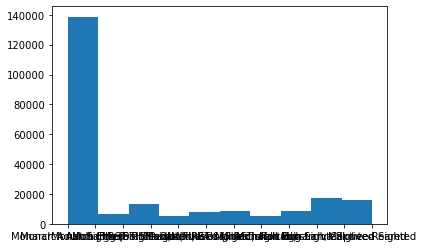

In [9]:
plt.hist(dt1['species'])

In [10]:
dt1.groupby('species')['species'].count()

species
Milkweed (FIRST sighted)           8465
Milkweed Sighted                   1721
Monarch (OTHER Observations)      13581
Monarch Adult (FIRST sighted)     36409
Monarch Adult Sighted            102306
Monarch Egg (FIRST sighted)        6876
Monarch Egg Sighted                8736
Monarch Fall Roost                 5035
Monarch Larva (FIRST sighted)      4898
Monarch Larva Sighted             17378
Monarch PEAK Migration             7689
Monarch, Captive-Reared           14339
Name: species, dtype: int64

# 2: Cleaning

I've decided to narrow the dataset to the years 2015-2020, and as I'm mainly concerned with the fall migration, exclude any observations before August.

Since I'm looking at "peak migration" numbers and fall roosts, I'm also excluding any observations that number the monarchs between 2 and 9. Many observations were coded with the number as 1, and many were for hundreds or thousands of monarchs, so I will keep those.

I also noticed some observations were included which were west of the Rockies. This is a separate population, so I excluded any observations with a longitude of greater than -105.

In [170]:
# Selecting only Fall roosts and peak migration observations
migration = pd.DataFrame(dt1.loc[((dt1['species'] == 'Monarch Fall Roost') | (dt1['species'] == 'Monarch PEAK Migration'))])

In [171]:
#drop unused columns
migration.drop(['flag_location', 'school', 'grade', 'customerid', 'number_old', 'flag_number', 'flag_species', 'species_old'], axis=1, inplace=True)

In [172]:
migration['year'] = migration['sighting_date_datetime'].dt.year
migration['month'] = migration['sighting_date_datetime'].dt.month
migration['month_name'] = migration['sighting_date_datetime'].dt.month_name()
migration['week_num'] = migration['sighting_date_datetime'].dt.isocalendar().week

In [173]:
migration.head()

,id,sighting_date,species,number,latitude,longitude,comments,image_url,sighting_date_datetime,year,month,month_name,week_num
3541,966119477,2000-08-08,Monarch PEAK Migration,1,47.066,-94.504,The first signs of the migration in Minnesota ...,NaN,2000-08-08,2000,8,August,32
3544,966258999,2000-08-15,Monarch PEAK Migration,1,44.957,-93.540,I observed the first big pulse of fall migrati...,NaN,2000-08-15,2000,8,August,33
3547,966374597,2000-08-15,Monarch PEAK Migration,1,45.009,-93.340,Lots of Monarch activity today! We counted 58...,NaN,2000-08-15,2000,8,August,33
3551,966612408,2000-08-17,Monarch PEAK Migration,1,45.050,-93.210,The day was an exciting one. We had about 75 b...,NaN,2000-08-17,2000,8,August,33
3572,966879879,2000-08-20,Monarch PEAK Migration,1,46.926,-96.850,It was totally awesome. It was about 4:30pm on...,NaN,2000-08-20,2000,8,August,33


In [174]:
migration.groupby('year')['year'].count()

year
2000     176
2001     253
2002      73
2003     210
2004     131
2005     512
2006     584
2007     609
2008     348
2009     402
2010     809
2011     582
2012     520
2013     348
2014     863
2015     920
2016     692
2017     907
2018    1527
2019    1452
2020     806
Name: year, dtype: int64

In [176]:
migration.groupby('species')['species'].count()

species
Milkweed (FIRST sighted)            0
Milkweed Sighted                    0
Monarch (OTHER Observations)        0
Monarch Adult (FIRST sighted)       0
Monarch Adult Sighted               0
Monarch Egg (FIRST sighted)         0
Monarch Egg Sighted                 0
Monarch Fall Roost               5035
Monarch Larva (FIRST sighted)       0
Monarch Larva Sighted               0
Monarch PEAK Migration           7689
Monarch, Captive-Reared             0
Name: species, dtype: int64

In [177]:
migration.shape

(12724, 13)

In [178]:
# Select only years 2015 onward
migration = migration[migration['year'] > 2014] 

In [179]:
# Selecting only months 8-11
migration = migration[migration['month'] > 7]
migration = migration[migration['month'] < 12]

In [180]:
# Selecting only observations of more than 9 butterflies or 1 (as many are coded incorrectly as 1)
migration = migration.loc[(migration['number'] == 1) | (migration['number'] > 9)]

In [181]:
# Selecting only Eastern monarchs
migration = migration[migration['longitude'] > -105] 

In [182]:
migration.shape

(5994, 13)

In [184]:
# Creating a datafram to store stats for each month and year
stats = pd.DataFrame(columns=['year', 'month', '25%', 'median', '75%', 'num_observations'])

In [185]:
# Iterates through each year and month and calculated the statistics of the latitude of the migration

# Each year from 2015-2020
for year in range(2015, 2021):
    # Iterates through each month August-Nov
    for month in range(8, 12):
        df = migration.loc[(migration['year'] == year) & (migration['month'] == month)]
        df_stats = df[['latitude']].describe()

        #add new row to end of DataFrame
        stats.loc[len(stats.index)] = [year, month, df_stats.iloc[4,0], df_stats.iloc[5,0], df_stats.iloc[6,0], df_stats.iloc[0,0]]

In [186]:
stats.year = stats.year.astype(int)
stats.month = stats.month.astype(int)
stats.num_observations = stats.num_observations.astype(int)

In [187]:
stats.head()

,year,month,25%,median,75%,num_observations
0,2015,8,44.32900,44.8115,45.1100,40
1,2015,9,39.60675,41.3840,42.6670,398
2,2015,10,27.02500,30.8390,33.7555,390
3,2015,11,21.51500,23.0330,24.6435,51
4,2016,8,43.86100,44.7690,45.6440,15


In [188]:
# Add a row for each month with the average for all years 2015-2020
# Iterates through each month August-Nov
for month in range(8, 12):
    df = migration.loc[(migration['month'] == month)]
    df_stats = df[['latitude']].describe()

    #add new row to end of DataFrame
    stats.loc[len(stats.index)] = ["All", month, df_stats.iloc[4,0], df_stats.iloc[5,0], df_stats.iloc[6,0], df_stats.iloc[0,0]]

In [189]:
stats.tail()

,year,month,25%,median,75%,num_observations
23,2020,11,29.41375,38.934,38.9340,10.0
24,All,8,43.69225,44.561,45.3295,512.0
25,All,9,39.92300,41.631,43.0730,2977.0
26,All,10,30.21700,33.639,38.1380,2301.0
27,All,11,21.29600,25.638,30.0740,204.0


In [190]:
stats.num_observations = stats.num_observations.astype(int)
stats.year = stats.year.astype('category')

In [191]:
migration.shape

(5994, 13)

In [192]:
# Save migration dataset and stats for use elsewhere
stats.to_csv('migration_stats.csv')
migration.to_csv('migration2015-2020.csv')

# 3: Mapping Fall Migration Latitudes

In [194]:
# Let's get the basic location data for Chicago, just to get started
address = 'Chicago, IL'

geolocator = Nominatim(user_agent="sje_monarch")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


In [198]:
# Make a map with median lines for multiple months, for all years
map_lat = folium.Map(location=[latitude-10, longitude+5], zoom_start=4)

# Add August
aug_all = stats.loc[(stats['month'] == 8) & (stats['year'] == 'All')]
med_lat = aug_all['median'].iloc[0]
med_line = [(med_lat, -100), (med_lat, -60)]
q1_lat = aug_all['25%'].iloc[0]
q3_lat = aug_all['75%'].iloc[0]

# Add box for Q1-Q3
folium.Polygon([(q1_lat, -100), (q3_lat, -100), (q3_lat, -60), (q1_lat, -60)],
               color="blue",
               weight=0,
               fill=True,
               fill_color="orange",
               fill_opacity=0.3).add_to(map_lat)
# Add line for median
folium.PolyLine(med_line,
                color='orange',
                weight=8,
                opacity=0.8).add_to(map_lat)
# Add label for median line
marker = folium.Marker(
    location=[med_lat, longitude],
    icon=folium.DivIcon(html=f"""
      <div style="color:black;background:#fff;width:60px;text-align:center;">August</div>
    """))
marker.add_to(map_lat)

# Add September
sep_all = stats.loc[(stats['month'] == 9) & (stats['year'] == 'All')]
med_lat = sep_all['median'].iloc[0]
med_line = [(med_lat, -103.33), (med_lat, -65)]
q1_lat = sep_all['25%'].iloc[0]
q3_lat = sep_all['75%'].iloc[0]

# Add box for Q1-Q3
folium.Polygon([(q1_lat, -103.33), (q3_lat, -103.33), (q3_lat, -65), (q1_lat, -65)],
               color="blue",
               weight=0,
               fill=True,
               fill_color="orange",
               fill_opacity=0.3).add_to(map_lat)
# Add line for median
folium.PolyLine(med_line,
                color='orange',
                weight=8,
                opacity=0.8).add_to(map_lat)
# Add label for median line
marker = folium.Marker(
    location=[med_lat, longitude],
    icon=folium.DivIcon(html=f"""
      <div style="color:black;background:#fff;width:60px;text-align:center;">September</div>
    """))
marker.add_to(map_lat)

# Add October
oct_all = stats.loc[(stats['month'] == 10) & (stats['year'] == 'All')]
med_lat = oct_all['median'].iloc[0]
med_line = [(med_lat, -106.66), (med_lat, -70)]
q1_lat = oct_all['25%'].iloc[0]
q3_lat = oct_all['75%'].iloc[0]

# Add box for Q1-Q3
folium.Polygon([(q1_lat, -106.66), (q3_lat, -106.66), (q3_lat, -70), (q1_lat, -70)],
               color="blue",
               weight=0,
               fill=True,
               fill_color="orange",
               fill_opacity=0.3).add_to(map_lat)
# Add line for median
folium.PolyLine(med_line,
                color='orange',
                weight=8,
                opacity=0.8).add_to(map_lat)
# Add label for median line
marker = folium.Marker(
    location=[med_lat, longitude],
    icon=folium.DivIcon(html=f"""
      <div style="color:black;background:#fff;width:60px;text-align:center;">October</div>
    """))
marker.add_to(map_lat)

# Add November
nov_all = stats.loc[(stats['month'] == 11) & (stats['year'] == 'All')]
med_lat = nov_all['median'].iloc[0]
med_line = [(med_lat, -110), (med_lat, -90)]
q1_lat = nov_all['25%'].iloc[0]
q3_lat = nov_all['75%'].iloc[0]

# Add box for Q1-Q3
folium.Polygon([(q1_lat, -110), (q3_lat, -110), (q3_lat, -90), (q1_lat, -90)],
               color="blue",
               weight=0,
               fill=True,
               fill_color="orange",
               fill_opacity=0.3).add_to(map_lat)
# Add line for median
folium.PolyLine(med_line,
                color='orange',
                weight=8,
                opacity=0.8).add_to(map_lat)
# Add label for median line
marker = folium.Marker(
    location=[med_lat, -100],
    icon=folium.DivIcon(html=f"""
      <div style="color:black;background:#fff;width:60px;text-align:center;">November</div>
    """))
marker.add_to(map_lat)


# Add Title
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Median Fall Migration Latitudes 2015-2020</b></h3>
             '''
map_lat.get_root().html.add_child(folium.Element(title_html))

# Save map to html file
map_lat.save('MigrationLatitudes.html')

# Display map
map_lat

# Animating gif - the migration, week by week, for the year 2020

In [200]:
migration.groupby('year')['year'].count()

year
2015     879
2016     639
2017     847
2018    1470
2019    1401
2020     758
Name: year, dtype: int64

I chose to animate the migration for the year 2019, because it has more migration observations than the most recent year (2020)

Thanks to this tutorial for guidance:<br>
https://towardsdatascience.com/how-to-make-an-animated-gif-map-in-python-using-folium-and-imageio-91d3fc60d084


In [199]:
# Import libraries for animated gif
import os
import time

import imageio
import webbrowser
import fileinput

from os import path
from selenium import webdriver
from PIL import Image
from pathlib import Path

In [182]:
path = '/Users/samanthagoodman/Documents/monarch-migration/'

os.chdir(path)

# For each week of the migration season
for week in range(33,45):
    
    # Get a new df with observations taken during this week of 2020
    this_week = migration.loc[(migration['week_num'] == week) & (migration['year'] == 2019)]
    this_week = this_week.dropna()
    
    # Create a folium map showing the entire US/Mexico
    mig_map = folium.Map(location=[35.8755, -82.000], zoom_start=4)
    
    # add markers to map as little butterflies
    icon_url = "https://raw.githubusercontent.com/sjegoodman/monarch-migration/main/monarch_pic_small.png"
    for lat, lng in zip(this_week['latitude'], this_week['longitude']):
        icon = folium.features.CustomIcon(icon_url,
                                      icon_size=(14, 14))
        marker = folium.map.Marker([lat, lng], icon=icon)
        mig_map.add_child(marker)
    
    # Add year label to the map
    month = this_week['sighting_date_datetime'].min().strftime("%B")
    day = this_week['sighting_date_datetime'].min().day
    title_html = '''
                 <h3 align="left" style="font-size:22px"><b>{}</b></h3>
                 '''.format('&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;Reported Sightings:  ' + str(month) + ", 2019")   
    mig_map.get_root().html.add_child(folium.Element(title_html))
    
    # Save the map in the GifMap directory
    mig_map.save('GifMap/total_perWeek_' + str(week) + '.html')

In [183]:
# Turn ZoomControl off in each html file
for week in range(33,45):
    with fileinput.FileInput('GifMap/total_perWeek_' + str(week) + '.html', inplace=True) as file:
        for line in file:
            print(line.replace('zoomControl: true', 'zoomControl: false'), end='')

In [184]:
# Convert html files to png (screenshot each html page)

# We use a delay because we dont want to take a screenshot of the browser before the map is loaded
delay=2

# Set path used
path = '/Users/samanthagoodman/Documents/monarch-migration/GifMap'

os.chdir(path)

for i in range(33,45):
    fn='total_perWeek_' + str(i) + '.html'
    tmpurl='file://{path}/{mapfile}'.format(path=os.getcwd(),mapfile=fn)
    
    browser = webdriver.Chrome(executable_path=r'/Users/samanthagoodman/Documents/monarch-migration/chromedriver')
    browser.get(tmpurl)

    #Give the map tiles some time to load
    time.sleep(delay)
    browser.save_screenshot(str(i)+'total_perWeek_' + str(i) + '.png')
    browser.quit()
    
    #remove html files
    os.remove('total_perWeek_' + str(i) + '.html')

<ipython-input-184-431676c9f84b>:16: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome(executable_path=r'/Users/samanthagoodman/Documents/monarch-migration/chromedriver')


In [185]:
# Cropping images for better visualization

for i in range(33,45):
    image = Image.open(str(i)+'total_perWeek_' + str(i) + '.png')
    box = (0, 0, 1713, 1040)
    cropped_image = image.crop(box)
    cropped_image.save(str(i)+'total_perWeek_' + str(i) + '.png')

In [186]:
# Create Gif and remove each .png file

image_path = Path()

images = list(image_path.glob('*.png'))
images.sort()
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))
    os.remove(file_name)
    
imageio.mimwrite('GifMap.gif', image_list, fps=1.5)

# 4: Interactive Map
Interactive map of submitted observations, with pictures of roosts and peak migration events

In [203]:
# Create a subset of the migration dataframe where each observation has a submitted photo
migration_pics = migration.dropna()

In [213]:
# Create an interactive map with migration pictures

# August 2020
aug2020obs = migration_pics.loc[(migration['month'] == 8) & (migration['year'] == 2020)]

map_lat = folium.Map(location=[latitude, longitude+5], zoom_start=4)

title_html = '''
             <h3 align="center" style="font-size:20px"><b>August 2020</b></h3>
             '''
map_lat.get_root().html.add_child(folium.Element(title_html))



# Now add butterflies
icon_url = "https://raw.githubusercontent.com/sjegoodman/monarch-migration/main/monarch_pic_small.png"
for lat, lng, img_url in zip(aug2020obs['latitude'], aug2020obs['longitude'], aug2020obs['image_url']):
    icon = folium.features.CustomIcon(icon_url,
                                      icon_size=(14, 14))
    html = '<img src="{}"  width="200" height="200">'.format
    folium.Marker([lat, lng], tooltip=html(img_url), icon=icon).add_to(map_lat)

# Save map to html file
map_lat.save('Aug2020.html')

# Display map
map_lat


In [214]:
# Create an interactive map with migration pictures

# September 2020
aug2020obs = migration_pics.loc[(migration['month'] == 9) & (migration['year'] == 2020)]

map_lat = folium.Map(location=[latitude, longitude+5], zoom_start=4)

title_html = '''
             <h3 align="center" style="font-size:20px"><b>September 2020</b></h3>
             '''
map_lat.get_root().html.add_child(folium.Element(title_html))



# Now add butterflies
icon_url = "https://raw.githubusercontent.com/sjegoodman/monarch-migration/main/monarch_pic_small.png"
for lat, lng, img_url in zip(aug2020obs['latitude'], aug2020obs['longitude'], aug2020obs['image_url']):
    icon = folium.features.CustomIcon(icon_url,
                                      icon_size=(14, 14))
    html = '<img src="{}"  width="200" height="200">'.format
    folium.Marker([lat, lng], tooltip=html(img_url), icon=icon).add_to(map_lat)

    
# Save map to html file
map_lat.save('Sep2020.html')

# Display map
map_lat
